In [1]:
import os
import rebound
import reboundx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from timeit import default_timer as timer
import matplotlib.gridspec as gridspec

np.set_printoptions(precision=3)

%matplotlib inline

/Users/vkostov/anaconda3/envs/exoplanet/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  import sys


In [2]:
# Set up constants, etc
#
k = 0.01720209895 # Gaussian Grav Constant
gm = k**2 # units of AU, DAYS and solar masses
rsun_to_AU = 0.00465047
rsun = 6.9570e5 # lm
AU_ = 149.5978707e6 # km
km_to_au = 1/AU_
year = np.sqrt((4.*np.pi**2)/gm)
day_to_sec = 24.*60.*60
solar_radius_to_au = 0.00465047 # AU

In [3]:
# Set up system parameters
#
M1, M2, M3, M4 = 1.2, 1.15, 1.15, 1.12 # Masses for the four stars
R1, R2, R3, R4 = 1.26, 1.16, 1.16, 1.1 # Radii for the four stars (if you want to calcualate impact parameters)

P1, P2, P3 = 13.6, 10.3, 432. # Orbital periods in days of Binary A, Binary B and AB
Per = np.asarray([P1, P2, P3])
e0_1, e0_2, e0_3 = 0.075, 0.027, 0.322 # Eccentricity of Binary A, Binary B and AB
inc0_1, inc0_2, inc0_3 = np.radians(87.55), np.radians(87.52), np.radians(87.69) # Inclination of Binary A, Binary B and AB
omega1, omega2, omega3 = np.radians(160), np.radians(190), np.radians(325) # Argument of periastron of Binary A, Binary B and AB

t_ref = 8437.5 # Reference time in BJD - 2,450,000
t0_1, t0_2, t0_3 = t_ref - 8437.041, t_ref - 8443.3691, t_ref - 9070.05 
delta_t = np.asarray([t0_1, t0_2, t0_3])
MA = np.radians(360*delta_t/Per) # Mean anomaly of Binary A, Binary B and AB
MA1, MA2, MA3 = MA[0], MA[1], MA[2]

In [4]:
# Set up integration parameters
#
tmax = 1e5 # Duration of integration in days
nn_steps = int(1e5) # Integration cadence
times_ = 0. + np.linspace(0.,tmax,nn_steps)
#
# Set up arrays for the orbital parameters of the four stars
#
x1, y1, z1, e1, a1 = np.zeros(nn_steps), np.zeros(nn_steps), np.zeros(nn_steps), np.zeros(nn_steps), \
np.zeros(nn_steps)
x2, y2, z2, e2, a2 = np.zeros(nn_steps), np.zeros(nn_steps), np.zeros(nn_steps), np.zeros(nn_steps), \
np.zeros(nn_steps)
x3, y3, z3, e3, a3 = np.zeros(nn_steps), np.zeros(nn_steps), np.zeros(nn_steps), np.zeros(nn_steps), \
np.zeros(nn_steps)
x4, y4, z4, e4, a4 = np.zeros(nn_steps), np.zeros(nn_steps), np.zeros(nn_steps), np.zeros(nn_steps), \
np.zeros(nn_steps)

inc1, inc2, inc3 = np.zeros(nn_steps), np.zeros(nn_steps), np.zeros(nn_steps)

vx1, vy1, vz1 = np.zeros(nn_steps), np.zeros(nn_steps), np.zeros(nn_steps)
vx2, vy2, vz2 = np.zeros(nn_steps), np.zeros(nn_steps), np.zeros(nn_steps)
vx3, vy3, vz3 = np.zeros(nn_steps), np.zeros(nn_steps), np.zeros(nn_steps)
vx4, vy4, vz4 = np.zeros(nn_steps), np.zeros(nn_steps), np.zeros(nn_steps)

In [5]:
sim = rebound.Simulation()
sim.units = ('day','AU','Msun') # Rebound units
G = sim.G
sim.add(m = M1, hash="Aa")
sim.add(m = M2, P = P1, omega = omega1, e = e0_1, M = MA1, inc = inc0_1, Omega = 0, hash="Ab")
sim.add(m = M3, P = P3, omega = omega3, e = e0_3, M = MA3, inc = inc0_3, Omega = 0, hash="Ba")
sim.add(m = M4, P = P2, omega = omega2, e = e0_2, M = MA2, inc = inc0_2, \
        Omega = 0, hash="Bb", primary = sim.particles[2])
sim.t = t_ref

sim.move_to_com()
comA = sim.calculate_com(first=0, last=2) # COM of Binary A
comB = sim.calculate_com(first=2, last=4) # COM of Binary B
orbit_3 = comB.calculate_orbit(primary = comA, G = sim.G)  

In [6]:
# calculate initial conditions for B binary separately first
sim2 = rebound.Simulation()
sim2.units = ('day','AU','Msun') # Rebound units
sim2.add(m = M3)
sim2.add(m = M4, P = P2, omega = omega2, e = e0_2, M = MA2, inc = inc0_2, Omega = 0, hash="Bb")
sim2.move_to_com()
Ba = sim2.particles[0]
Bb = sim2.particles[1]

sim = rebound.Simulation()
sim.units = ('day','AU','Msun') # Rebound units
G = sim.G
sim.add(m = M1, hash="Aa")
sim.add(m = M2, P = P1, omega = omega1, e = e0_1, M = MA1, inc = inc0_1, Omega = 0, hash="Ab")

# add in the B COM as a single particle with all the mass
quad_P, quad_e, quad_inc, quad_omega, quad_M = P3, e0_3, inc0_3, omega3, MA3
quad_P, quad_e, quad_inc, quad_omega, quad_M
sim.add(m = M3+M4, P=quad_P, omega=quad_omega, e=quad_e, M=quad_M, inc=quad_inc, Omega=0, hash='Bcom')

# add the Ba and Bb particles using the precomputed offsets above and remove the COM particle
Bcom = sim.particles[-1]
sim.add(m = M3, hash="Ba", x=Bcom.x+Ba.x, y=Bcom.y+Ba.y, z=Bcom.z+Ba.z, vx=Bcom.vx+Ba.vx, vy=Bcom.vy+Ba.vy, vz=Bcom.vz+Ba.vz) 
sim.add(m = M4, hash="Bb", x=Bcom.x+Bb.x, y=Bcom.y+Bb.y, z=Bcom.z+Bb.z, vx=Bcom.vx+Bb.vx, vy=Bcom.vy+Bb.vy, vz=Bcom.vz+Bb.vz) 
sim.remove(index=2)
sim.move_to_com()
ps = sim.particles


sim.integrator = "ias15"
sim.dt = 0.1*min(P1,P2)
ps = sim.particles
        
start = timer()    
    
for ii, t in enumerate(times_):       
    sim.integrate(t)

    x1[ii], y1[ii], z1[ii] = ps["Aa"].x, ps["Aa"].y, ps["Aa"].z
    
    orbit_1 = ps["Ab"].calculate_orbit(primary=ps["Aa"])
    x2[ii], y2[ii], z2[ii], a1[ii], e1[ii], inc1[ii] = \
            ps["Ab"].x, ps["Ab"].y, ps["Ab"].z, orbit_1.a, orbit_1.e, orbit_1.inc

    comA = sim.calculate_com(first=0, last=2)
    comB = sim.calculate_com(first=2, last=4)
    orbit_3 = comB.calculate_orbit(primary = comA, G = sim.G)    
    x3[ii], y3[ii], z3[ii], a3[ii], e3[ii], inc3[ii] = \
            ps["Ba"].x, ps["Ba"].y, ps["Ba"].z, orbit_3.a, orbit_3.e, orbit_3.inc
    
    orbit_2 = ps["Bb"].calculate_orbit(primary=ps["Ba"])
    x4[ii], y4[ii], z4[ii], a2[ii], e2[ii], inc2[ii] = \
            ps["Bb"].x, ps["Bb"].y, ps["Bb"].z, orbit_2.a, orbit_2.e, orbit_2.inc
    
    vx1[ii], vy1[ii], vz1[ii] = ps["Aa"].vx, ps["Aa"].vy, ps["Aa"].vz
    vx2[ii], vy2[ii], vz2[ii] = ps["Ab"].vx, ps["Ab"].vy, ps["Ab"].vz
        
    if t == t_ref:#t0_bin:
        print(t, ps["Aa"].x, ps["Ab"].x, ps["Ba"].x, ps["Bb"].x)#, \
        
    if (ii > 0) and (ii % 50000 == 0):
        end = timer()
        print('Timestep '+str(ii) + ' [days] done. Integration time =', "%0.2f" % (end - start),'[sec]')
        
times = times_

Timestep 50000 [days] done. Integration time = 9.25 [sec]


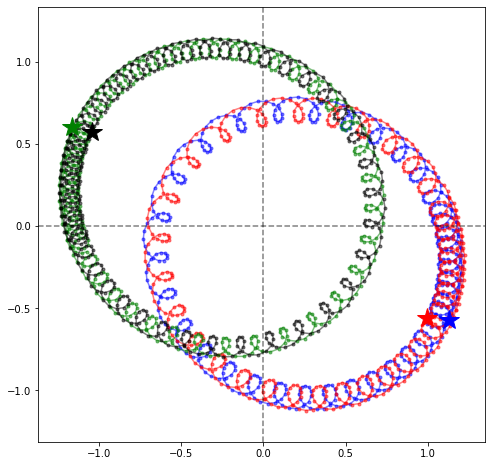

In [7]:
plt.figure(figsize=(8,8))

nn = 100
mm_ = 500
plt.plot(x1[0:mm_]+0./rsun_to_AU, z1[0:mm_]+0./rsun_to_AU, 'b.-', alpha = 0.5)
plt.plot(x2[0:mm_]+0./rsun_to_AU, z2[0:mm_]+0./rsun_to_AU, 'r.-', alpha = 0.5)
plt.plot(x3[0:mm_]+0./rsun_to_AU, z3[0:mm_]+0./rsun_to_AU, 'g.-', alpha = 0.5)
plt.plot(x4[0:mm_]+0./rsun_to_AU, z4[0:mm_]+0./rsun_to_AU, 'k.-', alpha = 0.5)

plt.plot(x1[0]+0./rsun_to_AU, z1[0]+0./rsun_to_AU, 'b*', ms = 20)# mfc = 'None')#, alpha = 0.5)
plt.plot(x2[0]+0./rsun_to_AU, z2[0]+0./rsun_to_AU, 'r*', ms = 20)#, mfc = 'None')#, alpha = 0.5)
plt.plot(x3[0]+0./rsun_to_AU, z3[0]+0./rsun_to_AU, 'g*', ms = 20)#, mfc = 'None')#, alpha = 0.5)
plt.plot(x4[0]+0./rsun_to_AU, z4[0]+0./rsun_to_AU, 'k*', ms = 20)#, mfc = 'None')#, alpha = 0.5)

plt.axhline(y = 0, color = 'k', ls = '--', alpha = 0.5)
plt.axvline(x = 0, color = 'k', ls = '--', alpha = 0.5)

plt.axis('equal')

plt.show()

(0.0, 5.0)

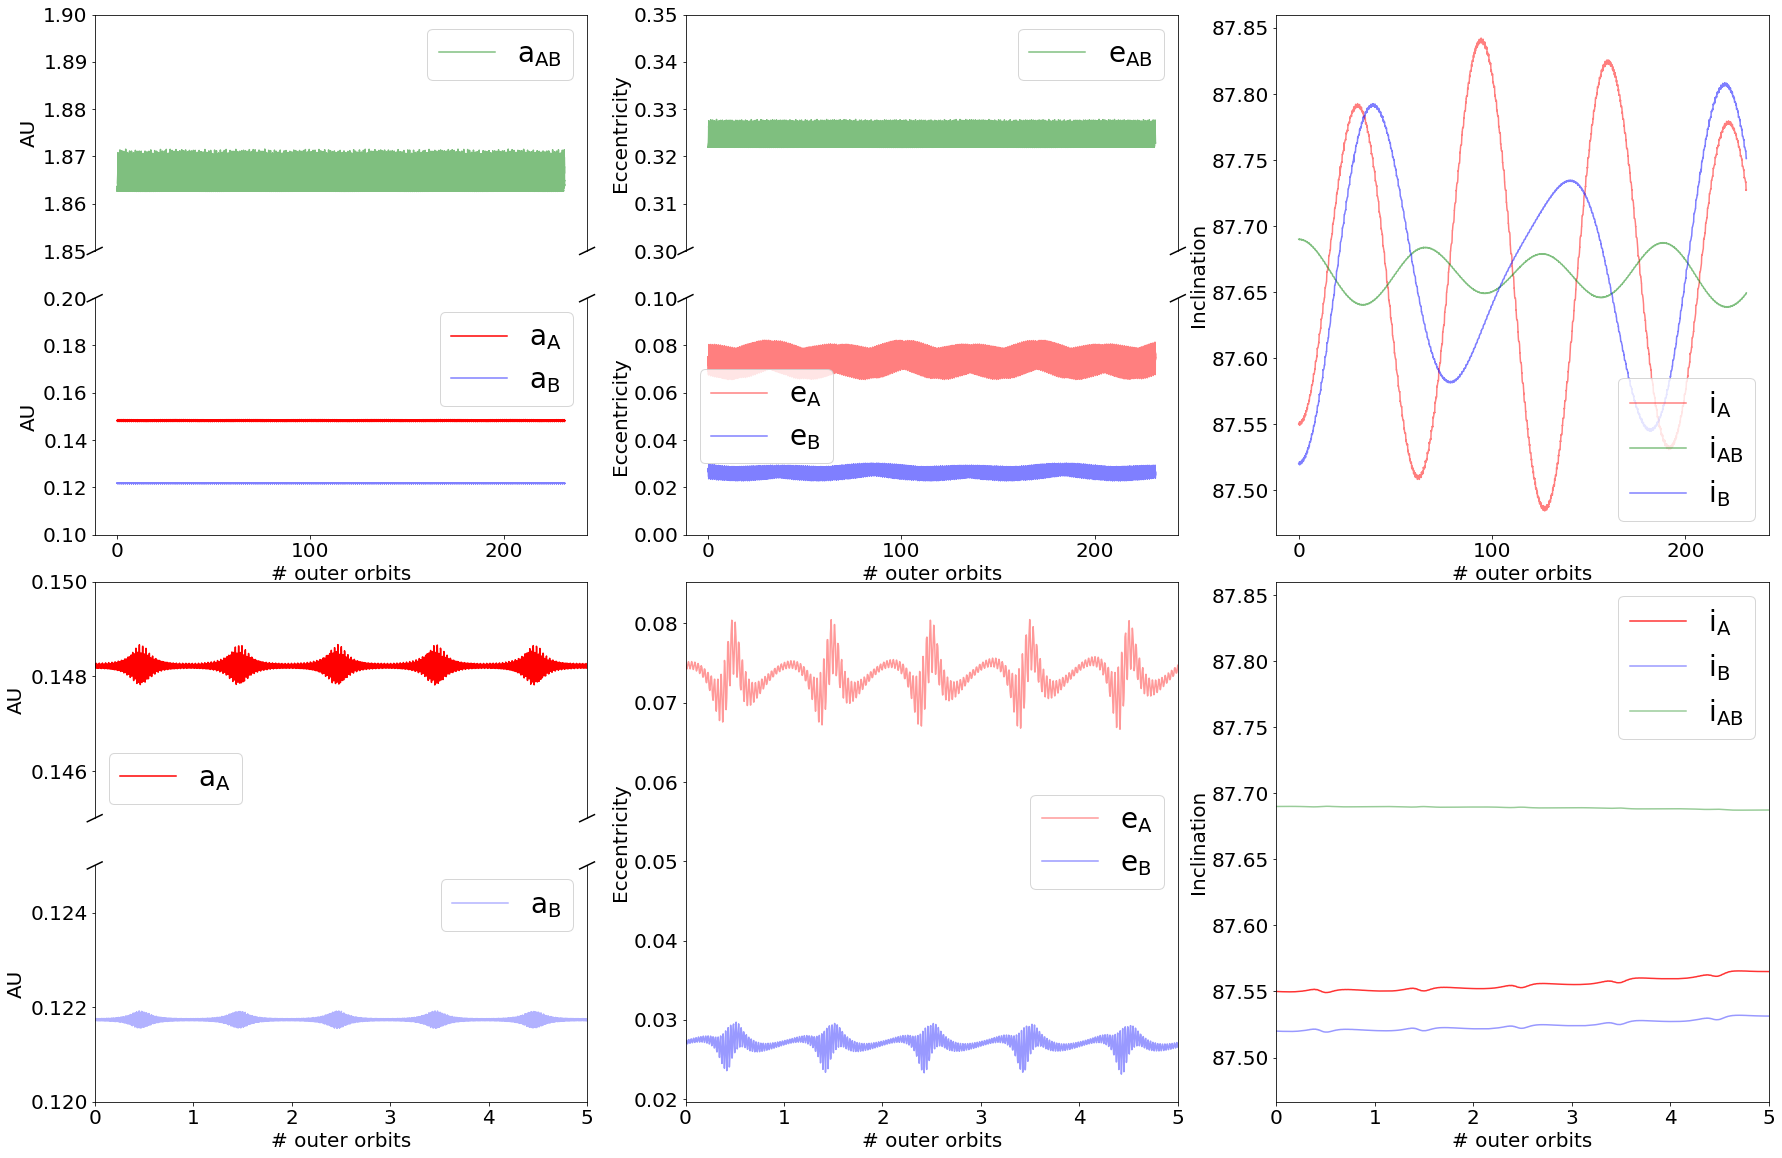

In [8]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(30,20))

outer_orbits = P3

mm_ = int(1e5)
nn_ = 1

a1_tmp, a2_tmp, a3_tmp = a1[0:mm_], a2[0:mm_], a3[0:mm_]
e1_tmp, e2_tmp, e3_tmp = e1[0:mm_], e2[0:mm_], e3[0:mm_]
inc1_tmp, inc2_tmp, inc3_tmp = inc1[0:mm_], inc2[0:mm_], inc3[0:mm_]
times_tmp = times[0:mm_]


gs = gridspec.GridSpec(4, 3)
#
#
#
ax00a = plt.subplot(gs[0, 0])
ax00a.plot(times_tmp[::nn_]/outer_orbits, a3_tmp[::nn_], 'g-', label = r'$\rm a_{AB}$', alpha = 0.5)
plt.ylabel('AU')
plt.legend(loc = 'best', fontsize = 28)

ax00b = plt.subplot(gs[1, 0])
ax00b.plot(times_tmp[::nn_]/outer_orbits, a1_tmp[::nn_], 'r-', label = r'$\rm a_A$', alpha = 1)
ax00b.plot(times_tmp[::nn_]/outer_orbits, a2_tmp[::nn_], 'b-', label = r'$\rm a_B$', alpha = 0.5)

ax00a.set_ylim(1.85, 1.9)
ax00b.set_ylim(0.1, 0.2) 

ax00a.spines['bottom'].set_visible(False)
ax00b.spines['top'].set_visible(False)
ax00a.set_xticks([])
ax00b.xaxis.tick_bottom()

d = .015 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax00a.transAxes, color='k', clip_on=False)
ax00a.plot((-d,+d),(-d,+d), **kwargs)      # top-left diagonal
ax00a.plot((1-d,1+d),(-d,+d), **kwargs)    # top-right diagonal

kwargs.update(transform=ax00b.transAxes)  # switch to the bottom axes
ax00b.plot((-d,+d),(1-d,1+d), **kwargs)   # bottom-left diagonal
ax00b.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-right diagonal
plt.xlabel('# outer orbits')
plt.ylabel('AU')
plt.locator_params(axis='x', nbins=5)
plt.legend(loc = 'best', fontsize = 28)
#
#
#
ax01a = plt.subplot(gs[0, 1])
ax01a.plot(times_tmp[::nn_]/outer_orbits, e3_tmp[::nn_], 'g-', label = r'$\rm e_{AB}$', alpha = 0.5)
plt.ylabel('Eccentricity')
plt.legend(loc = 'best', fontsize = 28)
plt.locator_params(axis='x', nbins=5)
#
ax01b = plt.subplot(gs[1, 1])
ax01b.plot(times_tmp[::nn_]/outer_orbits, e1_tmp[::nn_], 'r-', label = r'$\rm e_A$', ms = 3., alpha = 0.5)
ax01b.plot(times_tmp[::nn_]/outer_orbits, e2_tmp[::nn_], 'b-', label = r'$\rm e_B$', ms = 3., alpha = 0.5)

ax01a.set_ylim(0.3, 0.35)
ax01b.set_ylim(0., 0.1) 

ax01a.spines['bottom'].set_visible(False)
ax01b.spines['top'].set_visible(False)
ax01a.set_xticks([])
ax01b.xaxis.tick_bottom()

d = .015 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax01a.transAxes, color='k', clip_on=False)
ax01a.plot((-d,+d),(-d,+d), **kwargs)      # top-left diagonal
ax01a.plot((1-d,1+d),(-d,+d), **kwargs)    # top-right diagonal

kwargs.update(transform=ax01b.transAxes)  # switch to the bottom axes
ax01b.plot((-d,+d),(1-d,1+d), **kwargs)   # bottom-left diagonal
ax01b.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-right diagonal

plt.xlabel('# outer orbits')
plt.ylabel('Eccentricity')
plt.legend(loc = 'best', fontsize = 28)
plt.locator_params(axis='x', nbins=5)
#
#
#
ax02 = plt.subplot(gs[0:2, 2])#plt.subplot(233)
ax02.plot(times_tmp[::nn_]/outer_orbits, np.degrees(inc1_tmp[::nn_]), 'r-', label = r'$\rm i_A$', ms = 3., alpha = 0.5)
ax02.plot(times_tmp[::nn_]/outer_orbits, np.degrees(inc3_tmp[::nn_]), 'g-', label = r'$\rm i_{AB}$', alpha = 0.5)
ax02.plot(times_tmp[::nn_]/outer_orbits, np.degrees(inc2_tmp[::nn_]), 'b-', label = r'$\rm i_B$', ms = 3., alpha = 0.5)
plt.xlabel('# outer orbits')
plt.ylabel('Inclination')
plt.legend(loc = 'lower right', fontsize = 28)
plt.locator_params(axis='x', nbins=5)
#
#
#
ax03a = plt.subplot(gs[2, 0])
ax03a.plot(times_tmp[::nn_]/outer_orbits, a1_tmp[::nn_], 'r-', label = r'$\rm a_A$', alpha = 1)
plt.legend(loc = 'best', fontsize = 28)
plt.xlim(0., 5)
plt.ylabel('AU')

ax03b = plt.subplot(gs[3, 0])
ax03b.plot(times_tmp[::nn_]/outer_orbits, a2_tmp[::nn_], 'b-', label = r'$\rm a_B$', alpha = 0.3)

ax03a.set_ylim(0.145, 0.15)
ax03b.set_ylim(0.12, 0.125) 

ax03a.spines['bottom'].set_visible(False)
ax03b.spines['top'].set_visible(False)
ax03a.set_xticks([])
ax03b.xaxis.tick_bottom()

d = .015 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax03a.transAxes, color='k', clip_on=False)
ax03a.plot((-d,+d),(-d,+d), **kwargs)      # top-left diagonal
ax03a.plot((1-d,1+d),(-d,+d), **kwargs)    # top-right diagonal

kwargs.update(transform=ax03b.transAxes)  # switch to the bottom axes
ax03b.plot((-d,+d),(1-d,1+d), **kwargs)   # bottom-left diagonal
ax03b.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-right diagonal

plt.xlabel('# outer orbits')
plt.ylabel('AU')
plt.locator_params(axis='x', nbins=5)
plt.legend(loc = 'best', fontsize = 28)
plt.xlim(0., 5)
#
#
#
ax04 = plt.subplot(gs[2:, 1])
ax04.plot(times_tmp[::nn_]/outer_orbits, e1_tmp[::nn_], 'r-', label = r'$\rm e_A$', ms = 3., alpha = 0.4)
ax04.plot(times_tmp[::nn_]/outer_orbits, e2_tmp[::nn_], 'b-', label = r'$\rm e_B$', ms = 3., alpha = 0.4)
plt.xlabel('# outer orbits')
plt.ylabel('Eccentricity')
plt.legend(loc = 'best', fontsize = 28)
plt.locator_params(axis='x', nbins=5)
plt.xlim(0., 5)
#
#
#
ax05 = plt.subplot(gs[2:, 2])
ax05.plot(times_tmp[::nn_]/outer_orbits, np.degrees(inc1_tmp[::nn_]), 'r-', label = r'$\rm i_A$', ms = 3., alpha = 0.8)
ax05.plot(times_tmp[::nn_]/outer_orbits, np.degrees(inc2_tmp[::nn_]), 'b-', label = r'$\rm i_B$', ms = 3., alpha = 0.4)
ax05.plot(times_tmp[::nn_]/outer_orbits, np.degrees(inc3_tmp[::nn_]), 'g-', label = r'$\rm i_{AB}$', ms = 3., alpha = 0.4)
plt.xlabel('# outer orbits')
plt.ylabel('Inclination')
plt.legend(loc = 'best', fontsize = 28)
plt.locator_params(axis='x', nbins=5)
plt.xlim(0., 5)

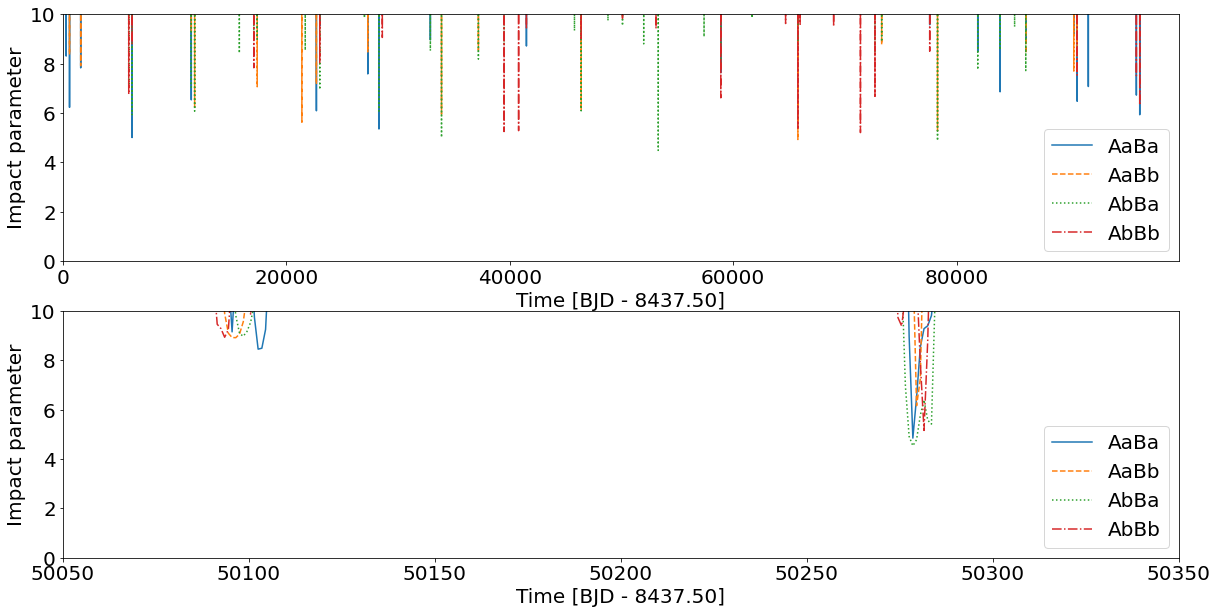

In [9]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,10))

bAaAb = np.sqrt((x1[:]/rsun_to_AU - x2[:]/rsun_to_AU)**2 + (y1[:]/rsun_to_AU - y2[:]/rsun_to_AU)**2)
bAaBa = np.sqrt((x1[:]/rsun_to_AU - x3[:]/rsun_to_AU)**2 + (y1[:]/rsun_to_AU - y3[:]/rsun_to_AU)**2)
bAaBb = np.sqrt((x1[:]/rsun_to_AU - x4[:]/rsun_to_AU)**2 + (y1[:]/rsun_to_AU - y4[:]/rsun_to_AU)**2)

bAbBa = np.sqrt((x2[:]/rsun_to_AU - x3[:]/rsun_to_AU)**2 + (y2[:]/rsun_to_AU - y3[:]/rsun_to_AU)**2)
bAbBb = np.sqrt((x2[:]/rsun_to_AU - x4[:]/rsun_to_AU)**2 + (y2[:]/rsun_to_AU - y4[:]/rsun_to_AU)**2)

bBaBb = np.sqrt((x3[:]/rsun_to_AU - x4[:]/rsun_to_AU)**2 + (y3[:]/rsun_to_AU - y4[:]/rsun_to_AU)**2)
#
plt.subplot(211)
nn_ = 100
plt.plot(times[::nn_], bAaBa[::nn_]/(R1 + R3), '-', label = 'AaBa')
plt.plot(times[::nn_], bAaBb[::nn_]/(R1 + R4), '--', label = 'AaBb')

plt.plot(times[::nn_], bAbBa[::nn_]/(R2 + R3), ':', label = 'AbBa')
plt.plot(times[::nn_], bAbBb[::nn_]/(R2 + R4), '-.', label = 'AbBb')

plt.ylim(0.,10)
plt.legend()
plt.ylabel('Impact parameter')
plt.xlabel('Time [BJD - ' + str("%0.2f" % t_ref) + ']')
plt.xlim(0., max(times[::nn_]))
#plt.xlim(50050,50350)
plt.legend(loc = 'lower right')

plt.subplot(212)
nn_ = 1
plt.plot(times[::nn_], bAaBa[::nn_]/(R1 + R3), '-', label = 'AaBa')
plt.plot(times[::nn_], bAaBb[::nn_]/(R1 + R4), '--', label = 'AaBb')

plt.plot(times[::nn_], bAbBa[::nn_]/(R2 + R3), ':', label = 'AbBa')
plt.plot(times[::nn_], bAbBb[::nn_]/(R2 + R4), '-.', label = 'AbBb')


plt.ylim(0.,10)
plt.legend()
plt.ylabel('Impact parameter')
plt.xlabel('Time [BJD - ' + str("%0.2f" % t_ref) + ']')
plt.xlim(0., max(times[::nn_]))
plt.xlim(50050,50350)

plt.legend(loc = 'lower right')

Text(0, 0.5, '$\\rm e_A$')

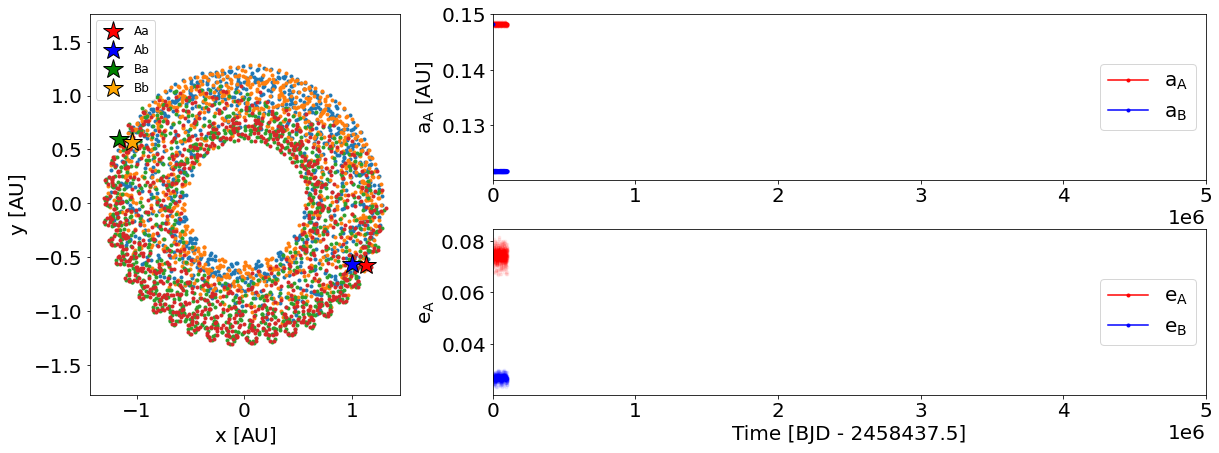

In [10]:
fig = plt.figure(figsize=(20,7))
grid = plt.GridSpec(2, 3, wspace=0.3, hspace=0.3)

plt.subplot(grid[:, 0])

mm_ = int(1.8e5)
nn_ = 100
x1_tmp, z1_tmp = x1[0:mm_] + 0./rsun_to_AU, z1[0:mm_] + 0./rsun_to_AU
x2_tmp, z2_tmp = x2[0:mm_] + 0./rsun_to_AU, z2[0:mm_] + 0./rsun_to_AU
x3_tmp, z3_tmp = x3[0:mm_] + 0./rsun_to_AU, z3[0:mm_] + 0./rsun_to_AU
x4_tmp, z4_tmp = x4[0:mm_] + 0./rsun_to_AU, z4[0:mm_] + 0./rsun_to_AU

plt.plot(x1_tmp[::nn_], z1_tmp[::nn_], '.')
plt.plot(x2_tmp[::nn_], z2_tmp[::nn_], '.')
plt.plot(x3_tmp[::nn_], z3_tmp[::nn_], '.')
plt.plot(x4_tmp[::nn_], z4_tmp[::nn_], '.')


plt.plot(x1_tmp[0], z1_tmp[0], 'r*', ms = 20, mec = 'k', label = 'Aa')
plt.plot(x2_tmp[0], z2_tmp[0], 'b*', ms = 20, mec = 'k', label = 'Ab')
plt.plot(x3_tmp[0], z3_tmp[0], 'g*', ms = 20, mec = 'k', label = 'Ba')
plt.plot(x4_tmp[0], z4_tmp[0], color = 'orange', marker= '*', ls = 'None', ms = 20, mec = 'k', label = 'Bb')
plt.xlabel(r'$\rm x\ [AU]$')
plt.ylabel(r'$\rm y\ [AU]$')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axis('equal')
plt.legend(loc = 'upper left', fontsize = 12)


plt.subplot(grid[0, 1:])
mm_ = int(1e5)
nn_ = 100
plt.plot(times[::nn_], a1[::nn_], 'r.-', alpha = 0.05)
plt.plot(times[0], a1[0], 'r.-', alpha = 1, label = r'$\rm a_A$')

plt.plot(times[::nn_], a2[::nn_], 'b.-', alpha = 0.05)
plt.plot(times[0], a1[0], 'b.-', alpha = 1, label = r'$\rm a_B$')
plt.xlim(0,5e6)
plt.legend(loc = 'center right')
plt.ylabel(r'$\rm a_A\ [AU]$')

plt.subplot(grid[1, 1:])
mm_ = int(1e5)
nn_ = 100
plt.plot(times[::nn_], e1[::nn_], 'r.-', alpha = 0.05)
plt.plot(times[0], e1[0], 'r.-', alpha = 1, label = r'$\rm e_A$')

plt.plot(times[::nn_], e2[::nn_], 'b.-', alpha = 0.05)
plt.plot(times[0], e2[0], 'b.-', alpha = 1, label = r'$\rm e_B$')
plt.xlim(0,5e6)
plt.xlabel('Time [BJD - 2458437.5]')
plt.legend(loc = 'center right')
plt.ylabel(r'$\rm e_A$')